In [1]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

**Данные:**

Import/Export Price Indexes: Asia https://www.quandl.com/data/BLSN/EIUIH1422-Import-Export-Price-Indexes-Asia

In [3]:
df = pd.read_csv('BLSN-EIUIH1422.csv', index_col=['Date'], parse_dates=['Date'], dayfirst=True)
df = df.sort_index()

In [4]:
df.head(3)

,Value
Date,
2006-03-31,111.1
2006-04-30,105.7
2006-05-31,117.3


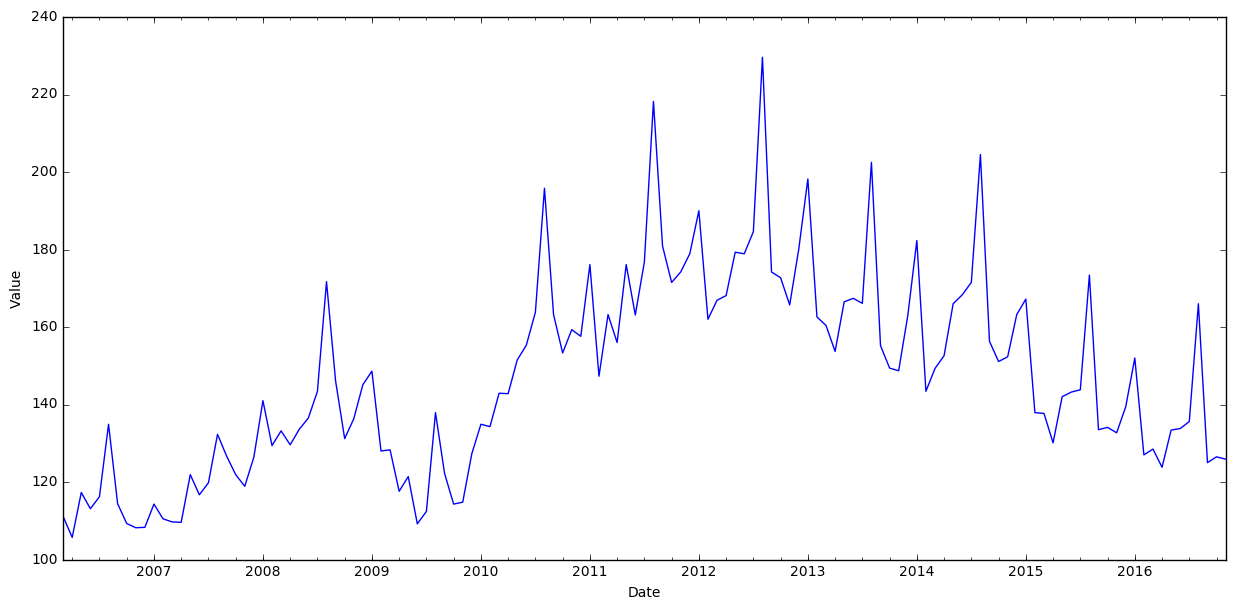

In [5]:
plt.figure(figsize(15,7))
df.Value.plot()
plt.ylabel('Value')
pylab.show()

Взглянув на график сразу видна сезонность ряда, а также имеющийся восходящий тренд. Также можно увидеть, что дисперсия нестабильна. Все это говорит о том, что данный ряд не является стационарным.

Проверим стационарность ряда по критерию Дики-Фуллера:

Критерий Дики-Фуллера: p=0.209571


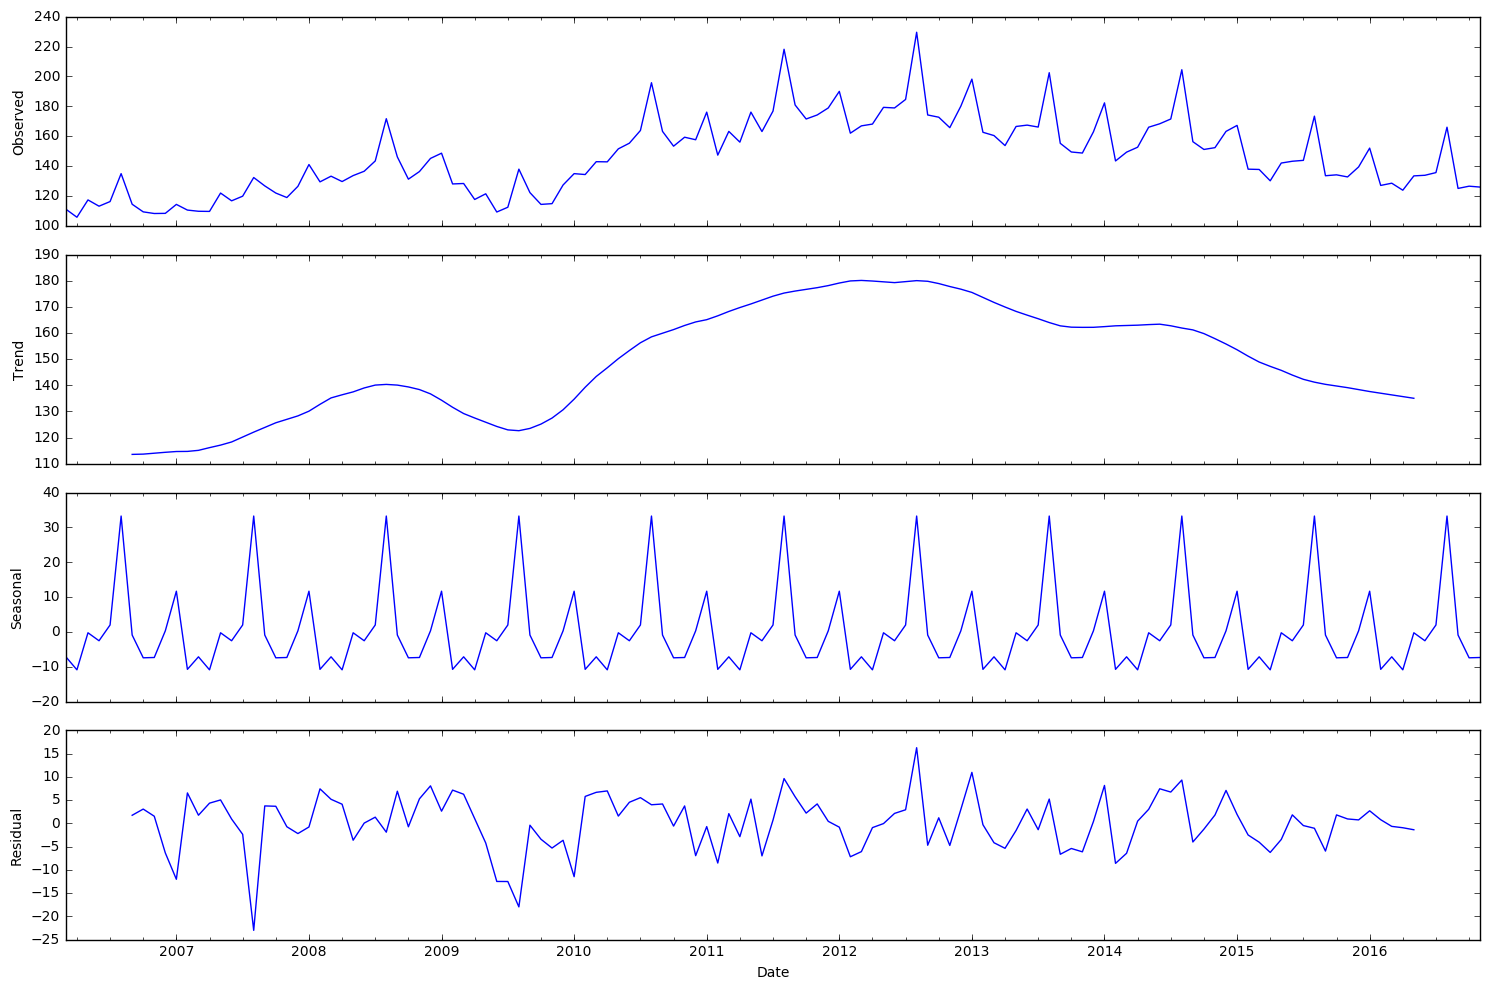

In [6]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.Value).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Value)[1])

Критерий Дики-Фуллера подтвердил догадки после визуального анализа данных ряда. Он не является стационарным.

**Выполним преобразование Бокса-Кокса для стабилизации дисперсии:**

Оптимальный параметр преобразования Бокса-Кокса: -0.424117


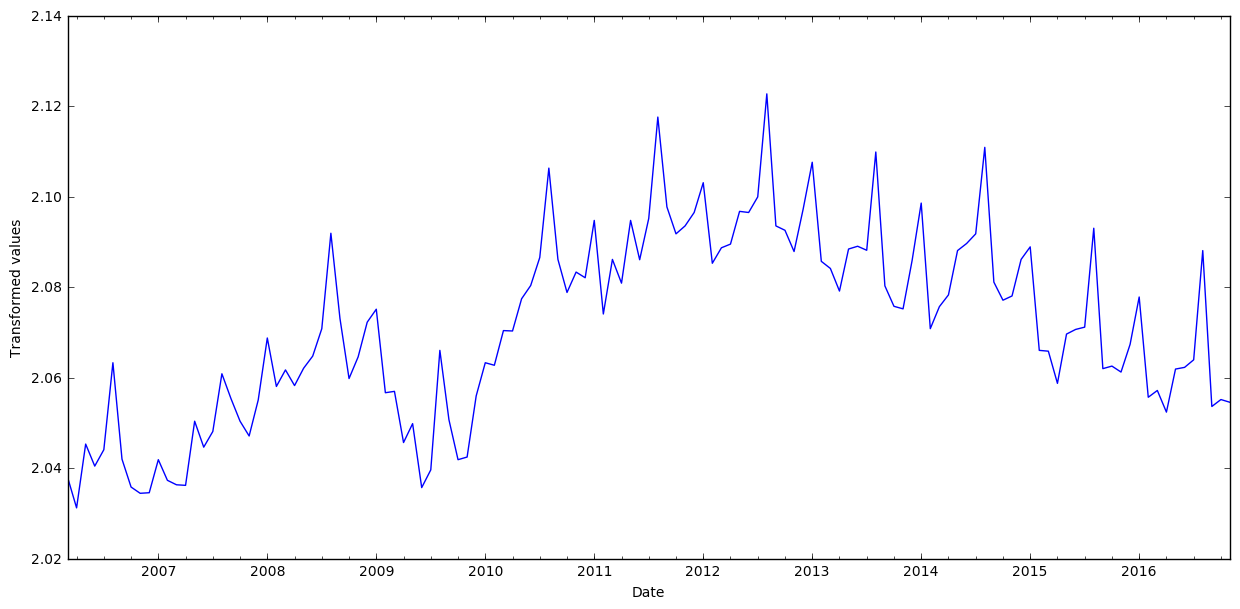

In [7]:
df['value_box'], lmbda = stats.boxcox(df.Value)
plt.figure(figsize(15,7))
df.value_box.plot()
plt.ylabel(u'Transformed values')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

**Попытаемся добиться стационарности ряда. Выполним сезонное дифференциирование:**

Критерий Дики-Фуллера: p=0.542003


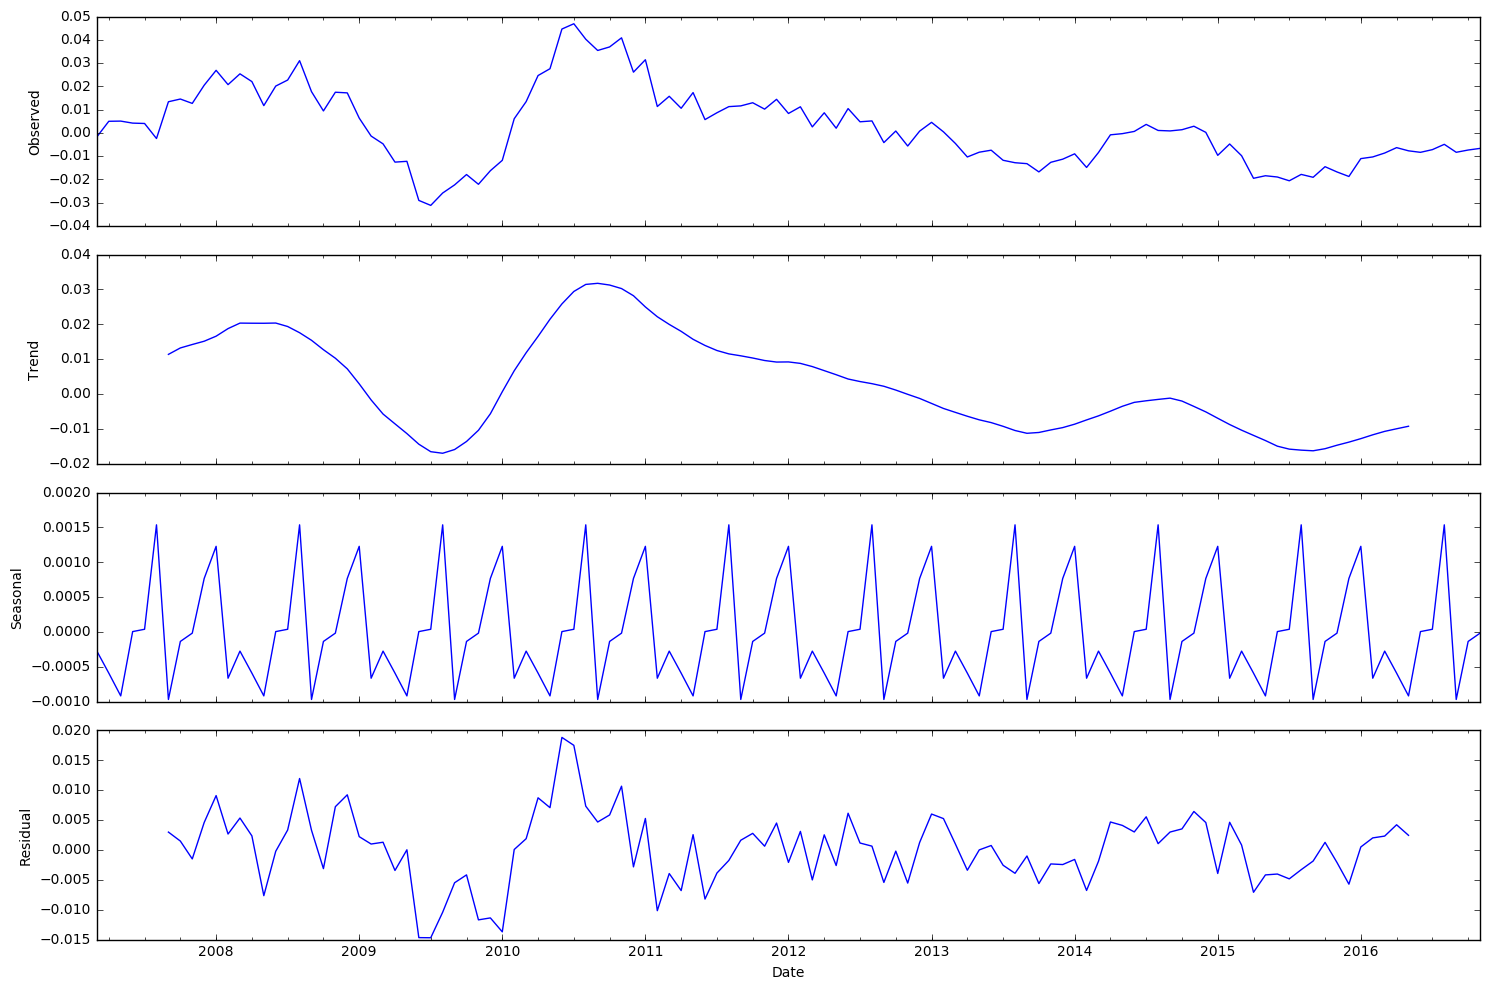

In [8]:
df['value_box_diff'] = df.value_box - df.value_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.value_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.value_box_diff[12:])[1])

Одного сезонного дифференциирования оказалось недостаточно, для того что бы наш ряд стал стационарным. Критерий Дики-Фуллера отвергает гипотезу о нестационарности. **Тогда сделаем еще одно простое дифференциирование ряда:**

Критерий Дики-Фуллера: p=0.009712


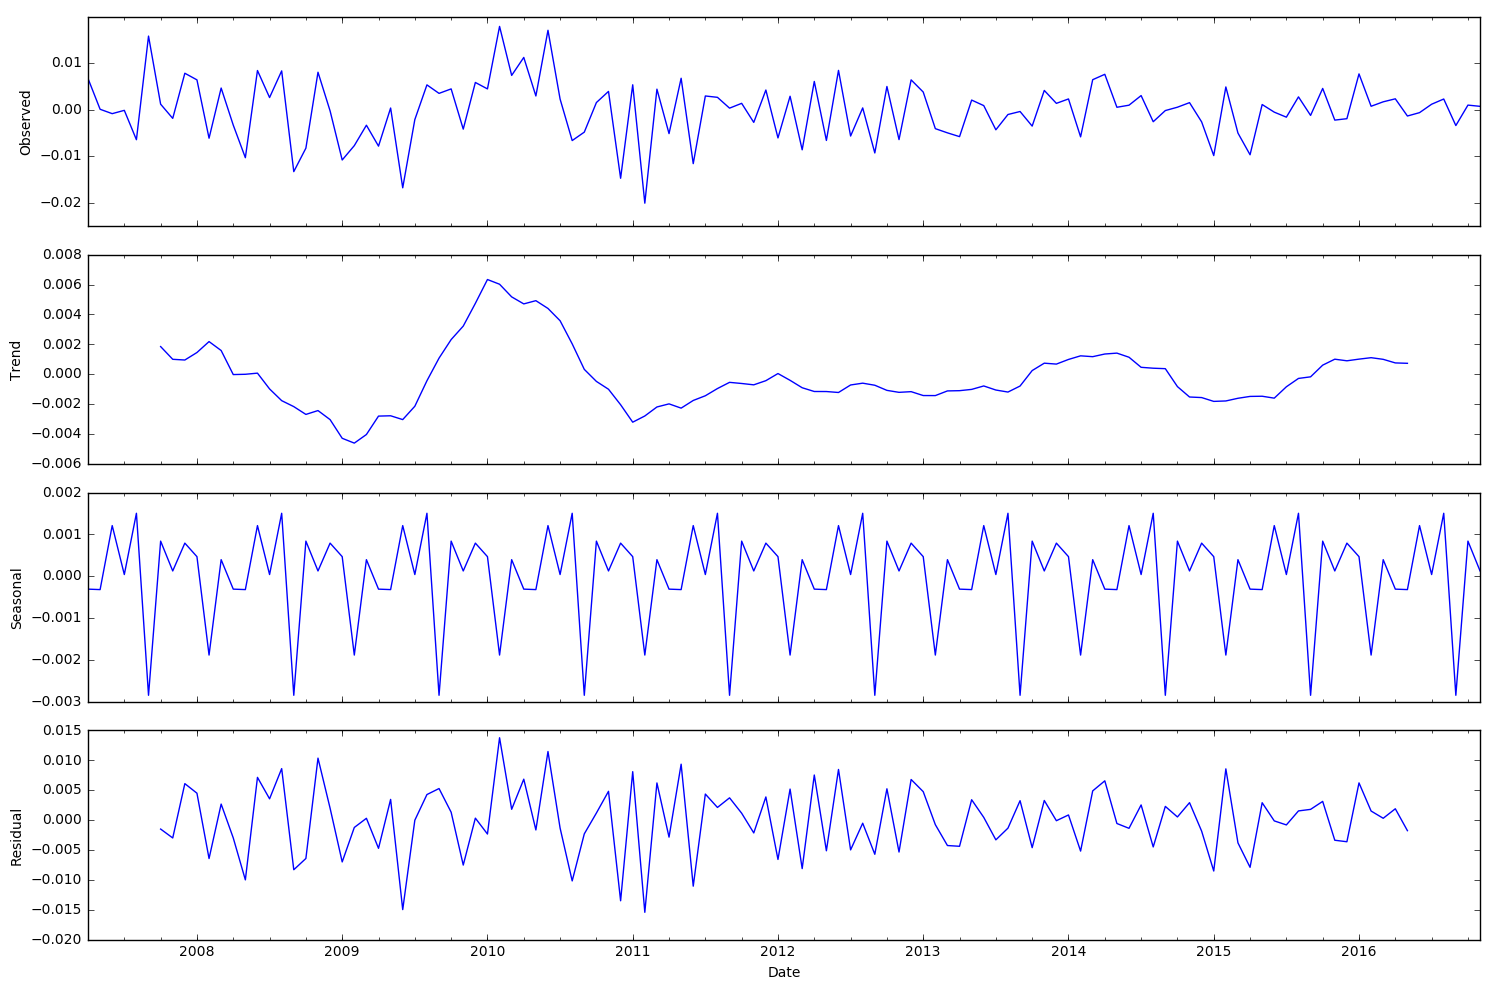

In [9]:
df['value_box_diff2'] = df.value_box_diff - df.value_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.value_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.value_box_diff2[13:])[1])

Критерий Дики-Фуллера отверг гипотезу о нестационарности

**Выполним первоначальный подбор параметров для будующей прогнозирующей модели:**

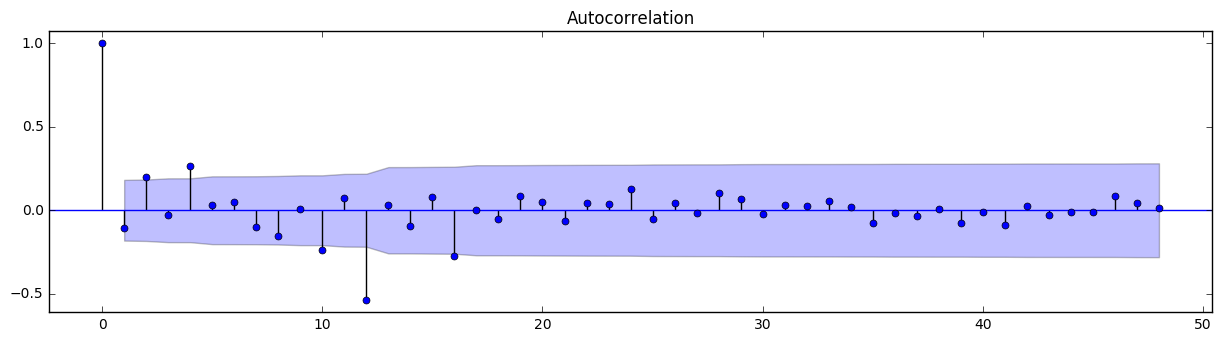

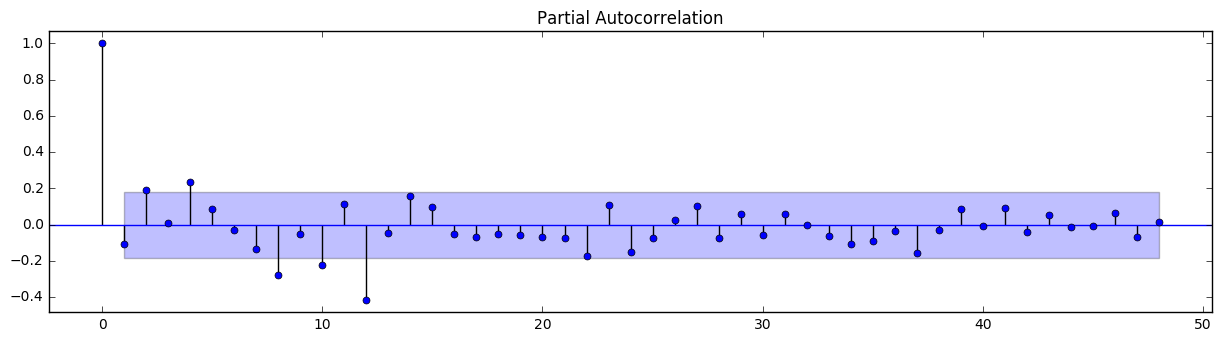

In [10]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.value_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.value_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

D = количество сезонных дифференцирований 

d = количество простых дифференцирований

Q = Из графика ACF номер последнего сезонного лага, при котором автокорреляция значима 

q = Из графика ACF номер последнего несезонного лага, при котором автокорреляция значима 

P = Из графика PACF номер последнего сезонного лага, при котором частичная автокорреляция значима

p = Из графика PACF номер последнего несезонного лага, при котором частичная автокорреляция значима

In [11]:
D=1
d=1
ps = range(0, 2)
qs = range(0, 5)
Ps = range(0, 2)
Qs = range(0, 5)

In [12]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

**Выполним подбор параметров по информационному критерию Акаике:**

In [13]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.value_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 3min 25s


In [14]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          value_box   No. Observations:                  129
Model:             SARIMAX(0, 1, 0)x(0, 1, 2, 12)   Log Likelihood                 445.419
Date:                            Sun, 18 Dec 2016   AIC                           -884.837
Time:                                    00:20:54   BIC                           -876.258
Sample:                                03-31-2006   HQIC                          -881.351
                                     - 11-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6811      0.090     -7.602      0.000      -0.857      -0.505
ma.S.L24       0.1814      0.093   

**Построим ее остатки:**

Критерий Стьюдента: p=0.730665
Критерий Дики-Фуллера: p=0.000000


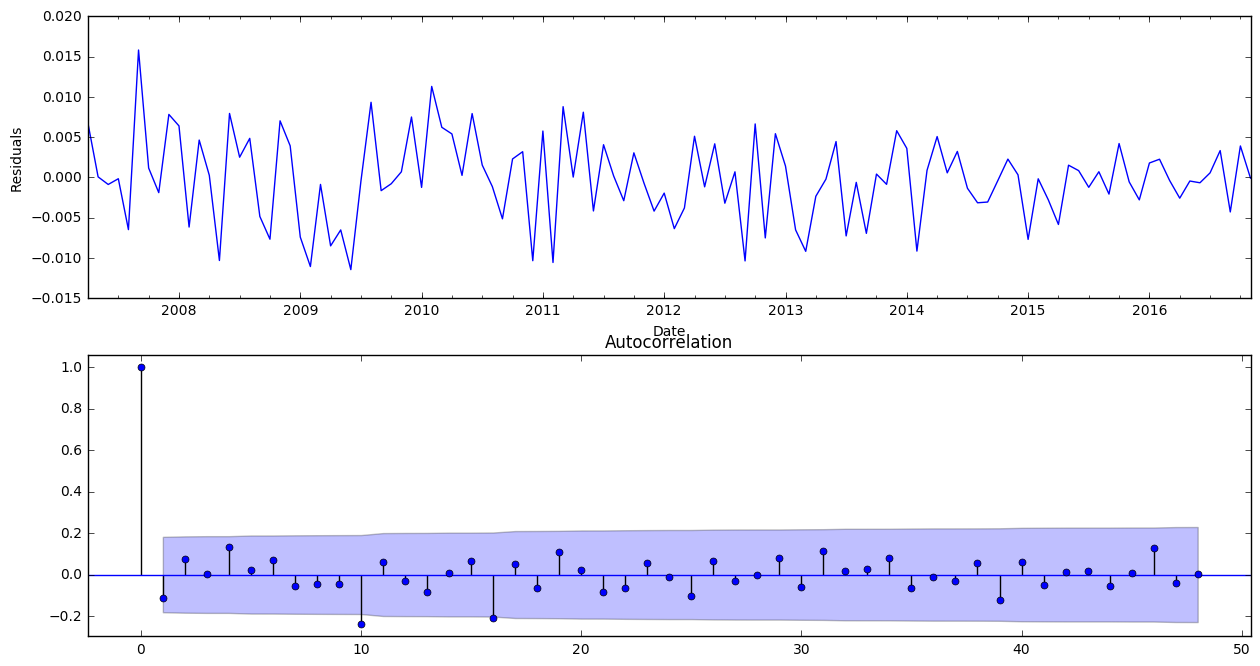

In [15]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

    - Остатки стационарны (Критерий Дики-Фуллера отвергает гипотезу нестационарности)
    - Неавтокоррелированы (видно из коррелограммы)
    - Несмещенные

**Посмотрим как модель описывает имеющиеся данные**

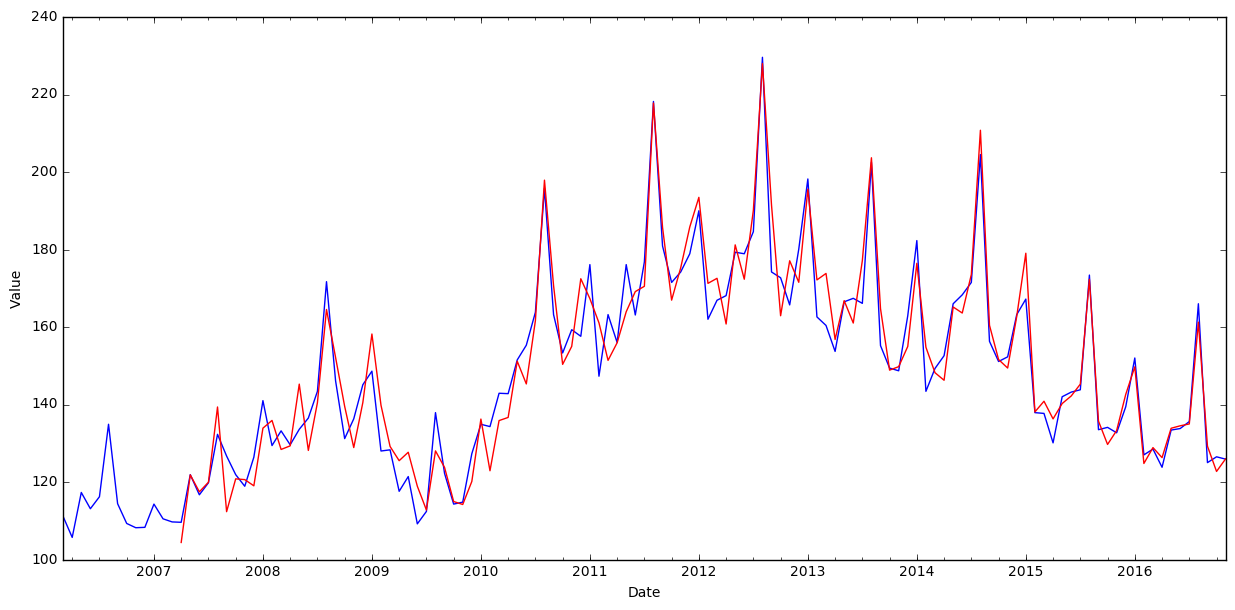

In [16]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.Value.plot()
df.model[13:].plot(color='r')
plt.ylabel('Value')
pylab.show()

**Составим прогноз**

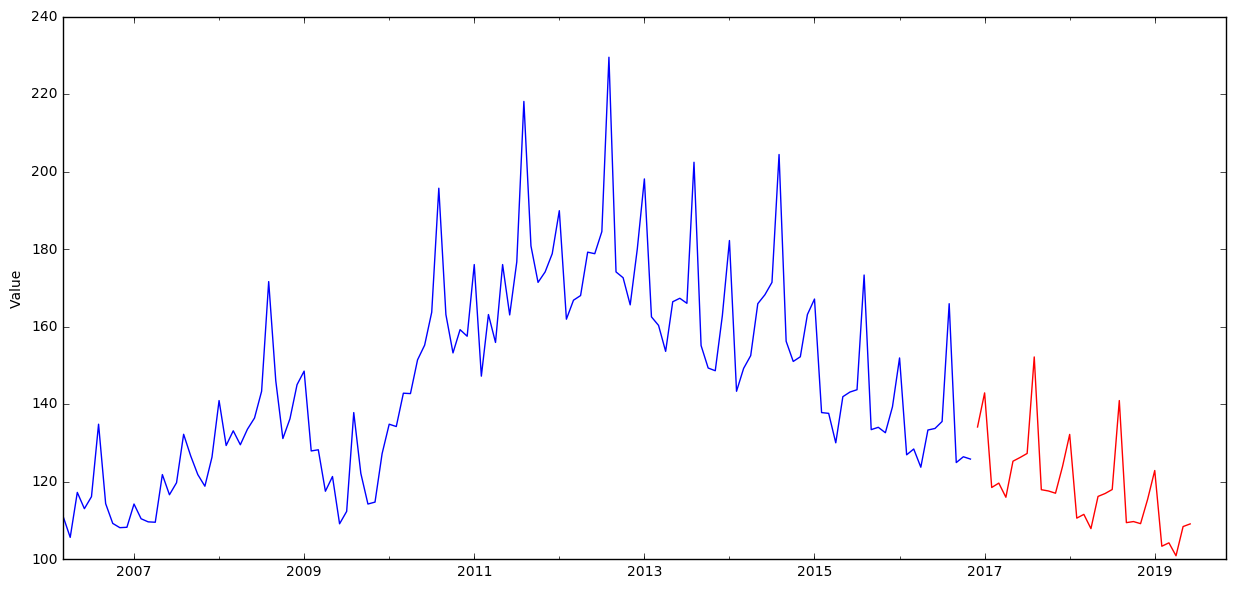

In [17]:
df2 = df[['Value']]
date_list = [datetime.datetime.strptime("2016-12-31", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=129, end=159), lmbda)

plt.figure(figsize(15,7))
df2.Value.plot()
df2.forecast.plot(color='r')
plt.ylabel('Value')
pylab.show()